In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# 1. Load dataset
df = pd.read_csv("ready_fraud_detection_dataset_new.csv")

# 2. Create numeric label
df['label'] = df['fraudulent'].map({'f': 0, 't': 1})

# 3. Drop any rows with missing full_text (just in case)
df = df.dropna(subset=['full_text'])


X = df['full_text']
y = df['label']

test_size = 0.10
val_size = 0.10
train_size = 0.80
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size/(train_size + val_size), stratify=y_temp, random_state=42)

In [ ]:
df

,full_text,fraudulent,label
0,marketing intern food weve created groundbreak...,f,0
1,customer service cloud video production second...,f,0
2,commissioning machinery assistant cma valor se...,f,0
3,account executive washington dc passion improv...,f,0
4,bill review manager spotsource solutions llc g...,f,0
...,...,...,...
17875,account director distribution vend looking awe...,f,0
17876,payroll accountant weblinc ecommerce platform ...,f,0
17877,project cost control staff engineer cost contr...,f,0
17878,graphic designer nemsia studios looking experi...,f,0


In [ ]:
# Debugging Block

print("DEBUGGING CHECKS")
print("Total rows in original df:", len(df))
print("NaNs in full_text:", df['full_text'].isna().sum())
print("Class distribution in full dataset:\n", df['label'].value_counts())
print("Size of X_train:", len(X_train))
print("Size of y_train:", len(y_train))
print("Size of X_test:", len(X_test))
print("Size of y_test:", len(y_test))
print("Size of X_val:", len(X_val))
print("Size of y_val:", len(y_val))

# Check for NaNs in training data
print("NaNs in X_train:", X_train.isna().sum())
print("NaNs in y_train:", y_train.isna().sum())

# Optional: Check if X_train has any empty strings
empty_text_count = (X_train.str.strip() == "").sum()
print("Empty string entries in X_train:", empty_text_count)

# Sanity check: X_train must not be empty
assert len(X_train) > 0, "X_train is EMPTY!"
assert X_train.isna().sum() == 0, "X_train contains NaNs!"

DEBUGGING CHECKS
Total rows in original df: 17880
NaNs in full_text: 0
Class distribution in full dataset:
 label
0    17014
1      866
Name: count, dtype: int64
Size of X_train: 14303
Size of y_train: 14303
Size of X_test: 1788
Size of y_test: 1788
Size of X_val: 1789
Size of y_val: 1789
NaNs in X_train: 0
NaNs in y_train: 0
Empty string entries in X_train: 0


In [ ]:
# 5. Convert X_train to DataFrame (required by RandomOverSampler)
X_train_df = pd.DataFrame({'text': X_train.values})

# Check the length before resampling
assert len(X_train_df) > 0, "X_train is empty!"

# 6. Apply Random Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_df, y_train)

# 7. Create DataFrame with resampled data
df_ros = pd.DataFrame({'text': X_ros['text'], 'label': y_ros})

# Final balanced train data without shuffling
X_train_balanced = df_ros['text'].tolist()
y_train_balanced = df_ros['label'].tolist()

In [ ]:
len(X_train_balanced)

27222

In [ ]:
df_ros

,text,label
0,customer service team lead novitex enterprise ...,0
1,growth hacker transifex founded dream revoluti...,0
2,entry level accounting specialist immediate op...,0
3,sr accountant wiredrive fast growing privately...,0
4,english teacher abroad help teachers get safe ...,0
...,...,...
27217,webcam model internet modeling premier adult m...,1
27218,technical program manager aptitude staffing so...,1
27219,office manager aptitude staffing solutions red...,1
27220,receptionist data entry office support seeking...,1


Original training set label counts: Counter({0: 13611, 1: 692})
Balanced training set label counts: Counter({0: 13611, 1: 13611})


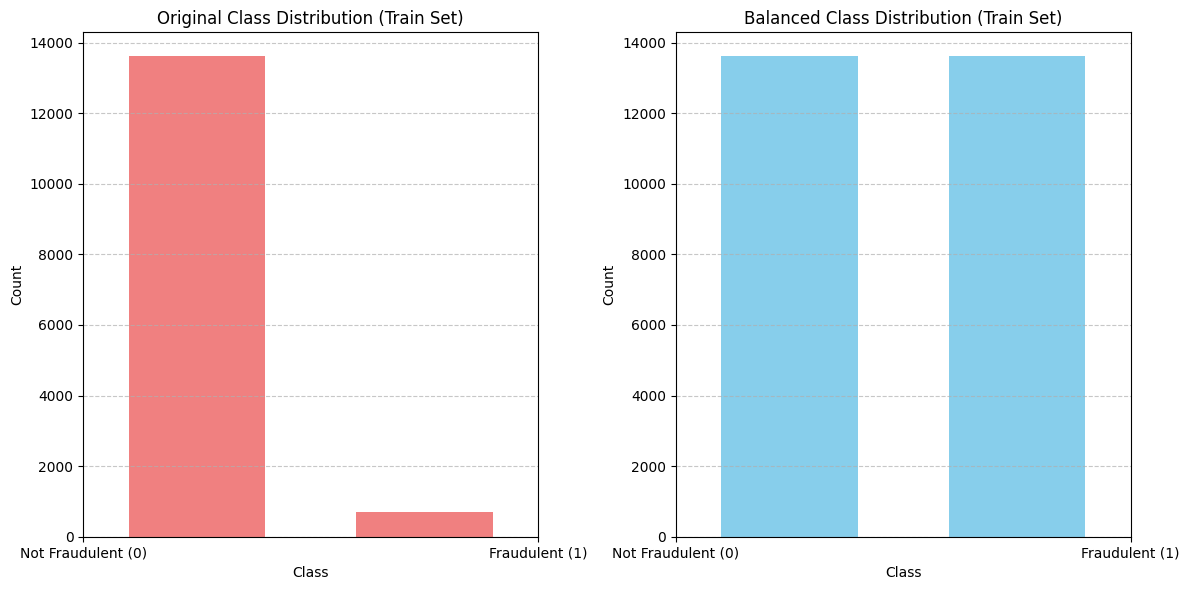

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Print label distributions before and after undersampling
print("Original training set label counts:", Counter(y_train))
print("Balanced training set label counts:", Counter(y_train_balanced))

# Create a figure with 2 subplots for before and after undersampling
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original distribution (before undersampling)
axes[0].hist(y_train, bins=2, rwidth=0.6, color='lightcoral')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Not Fraudulent (0)', 'Fraudulent (1)'])
axes[0].set_title("Original Class Distribution (Train Set)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Balanced distribution (after undersampling)
axes[1].hist(y_train_balanced, bins=2, rwidth=0.6, color='skyblue')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Not Fraudulent (0)', 'Fraudulent (1)'])
axes[1].set_title("Balanced Class Distribution (Train Set)")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize balanced training texts
train_encodings = tokenizer(
    X_train_balanced,
    padding='max_length', # ensures same length for all
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Tokenize original unbalanced test texts
test_encodings = tokenizer(
    list(X_test),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

# Tokenize original unbalanced val texts
val_encodings = tokenizer(
    list(X_val),
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Sample index to inspect
sample_idx = 5

# Show token IDs
print("Input IDs:", train_encodings['input_ids'][sample_idx])

# Show attention mask
print("Attention Mask:", train_encodings['attention_mask'][sample_idx])

# Decode tokens back to text for readability
decoded_text = tokenizer.decode(train_encodings['input_ids'][sample_idx], skip_special_tokens=True)
print("Decoded Text:\n", decoded_text)

Input IDs: tensor([  101,  4341,  3237, 18740,  3811,  7772,  3784,  5821,  4007,  2458,
         3813,  9403,  6734,  5392, 10760,  2540,  3534,  4514,  4056,  5094,
         2120,  7846,  6464,  4982,  4341, 27046,  2224, 16350,  2578,  4646,
         2974,  2241,  7300, 18740,  2580,  2702,  3388,  4346,  3643,  8144,
         2050,  6958,  4247,  3298,  3112,  3930,  3029,  2154,  6739,  9797,
         2892, 11263, 27989,  2389,  2780,  2147, 12824, 10895,  5676,  5147,
         3362,  4539,  6089, 18740,  5462,  3112, 18740,  3811,  7772,  3784,
         5821,  4007,  2458,  3813,  9403,  6734,  2627,  2086,  2499, 29454,
        29206, 14626,  4975,  4346,  2190,  4007,  2578, 12945, 16743, 19801,
        18740,  2580,  2702,  3388,  4346,  3643,  8144,  6958,  4247,  3298,
         3112,  3930,  3029,  2154,  2747,  6224,  4341, 12706,  6734,  6005,
         2181,  5052,  4855,  4007,  2326, 12945, 16743, 19801,  7427,  2560,
         2488, 15184, 10159,  4119,  2893,  2392,  32

In [ ]:
print(f"Length of encodings: {len(train_encodings['input_ids'])}")
print(f"Length of labels: {len(y_train_balanced)}")

Length of encodings: 27222
Length of labels: 27222


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if isinstance(self.labels, (list, torch.Tensor)):
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        else:
            item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERTCNNClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2):
        super(BERTCNNClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

        self.conv1 = nn.Conv1d(in_channels=768, out_channels=256, kernel_size=5, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.dropout = nn.Dropout(0.3)

        # Calculate flattened size after conv and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, 768, 512)  # batch=1, channels=768, seq_len=512
            x = self.relu(self.conv1(dummy_input))
            x = self.pool1(x)
            self.flattened_size = x.numel()  # total number of features

        self.fc = nn.Linear(self.flattened_size, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)

        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.flatten(x, start_dim=1)  # flatten except batch dim

        x = self.dropout(x)
        return self.fc(x)


class BERTLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_size=64, num_classes=2, num_layers=1, bidirectional=False):
        super(BERTLSTMClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        return self.fc(x)

class BERTCNNLSTMClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', num_classes=2,
                 cnn_out_channels1=256,
                 lstm_hidden_size=64, num_layers=1, bidirectional=False):
        super(BERTCNNLSTMClassifier, self).__init__()

        # BERT Model untuk menghasilkan embedding
        self.bert = BertModel.from_pretrained(bert_model_name)

        # CNN Layer
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=cnn_out_channels1, kernel_size=5, padding=1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)

        # Fully Connected Layer (untuk output klasifikasi)
        self.fc = nn.Linear(cnn_out_channels1 * 255 + (lstm_hidden_size * 2 if bidirectional else lstm_hidden_size), num_classes) # Adjusted input size for fc

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        # Mendapatkan embedding dari model BERT
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # CNN Branch
        cnn_out = x.permute(0, 2, 1)  # (batch, seq_len, channels) -> (batch, channels, seq_len) for CNN
        cnn_out = self.relu(self.conv1(cnn_out))
        cnn_out = self.pool1(cnn_out)  # CNN Pooling
        cnn_out = torch.flatten(cnn_out, start_dim=1) # Flatten the CNN output

        # LSTM Branch
        lstm_out, _ = self.lstm(x)  # Output LSTM
        lstm_out = lstm_out[:, -1, :]  # Mengambil output dari LSTM pada step terakhir (batch, hidden_size)

        # Menggabungkan hasil CNN dan LSTM
        combined_out = torch.cat((cnn_out, lstm_out), dim=1) # Concatenate 2D tensors

        # Dropout dan Fully Connected Layer
        combined_out = self.dropout(combined_out)
        out = self.fc(combined_out)

        return out

In [ ]:
train_dataset = TextDataset(train_encodings, y_train_balanced)
val_dataset = TextDataset(val_encodings, y_val)
test_dataset = TextDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def train_model_with_val_earlystopping(model, train_loader, val_loader, criterion, optimizer, device,
                                       num_epochs=10, patience=3, max_batches_per_epoch=None, plot_losses=True):
    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_preds_train, all_labels_train = [], []

        for i, batch in enumerate(train_loader):
            if max_batches_per_epoch and i >= max_batches_per_epoch:
                break

            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
            all_preds_train.extend(preds)
            all_labels_train.extend(labels.detach().cpu().numpy())

        avg_train_loss = train_loss / (i + 1)
        train_acc = accuracy_score(all_labels_train, all_preds_train)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds_val, all_labels_val = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds_val.extend(preds)
                all_labels_val.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels_val, all_preds_val)
        val_f1 = f1_score(all_labels_val, all_preds_val, average='macro')
        val_prec = precision_score(all_labels_val, all_preds_val, average='macro')
        val_rec = recall_score(all_labels_val, all_preds_val, average='macro')

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        history.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_acc': train_acc,
            'val_loss': avg_val_loss,
            'val_acc': val_acc,
            'val_precision': val_prec,
            'val_recall': val_rec,
            'val_f1': val_f1
        })

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return history


## CNN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

# Initialize your model, e.g., BERTCNNClassifier
cnn_model = BERTCNNClassifier(num_classes=2)
cnn_model.to(device)

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=2e-5)

# Train with early stopping and validation monitoring
history_cnn = train_model_with_val_earlystopping(
    cnn_model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=10, patience=3
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10 | Train Loss: 0.0999 | Val Loss: 0.0678 | Train Acc: 0.9602 | Val Acc: 0.9855 | Val F1: 0.9107
Epoch 2/10 | Train Loss: 0.0133 | Val Loss: 0.0507 | Train Acc: 0.9959 | Val Acc: 0.9905 | Val F1: 0.9460
Epoch 3/10 | Train Loss: 0.0052 | Val Loss: 0.0529 | Train Acc: 0.9986 | Val Acc: 0.9911 | Val F1: 0.9511
Epoch 4/10 | Train Loss: 0.0069 | Val Loss: 0.0716 | Train Acc: 0.9981 | Val Acc: 0.9871 | Val F1: 0.9338
Epoch 5/10 | Train Loss: 0.0046 | Val Loss: 0.0705 | Train Acc: 0.9989 | Val Acc: 0.9905 | Val F1: 0.9466
Early stopping at epoch 5


In [ ]:
training_cnn = pd.DataFrame(history_cnn)
training_cnn

,epoch,train_loss,train_acc,val_loss,val_acc,val_precision,val_recall,val_f1
0,1,0.099948,0.960216,0.067768,0.985467,0.977655,0.861481,0.910679
1,2,0.013271,0.995922,0.050690,0.990497,0.970560,0.924112,0.945994
2,3,0.005237,0.998604,0.052928,0.991056,0.956183,0.946219,0.951140
3,4,0.006934,0.998090,0.071573,0.987144,0.914599,0.955070,0.933771
4,5,0.004617,0.998898,0.070485,0.990497,0.965239,0.929566,0.946610


In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(df):
    # Plot 1: Train vs Validation Loss
    plt.figure(figsize=(5, 3))
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Validation Metrics
    plt.figure(figsize=(5, 3))
    plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
    plt.plot(df['epoch'], df['val_precision'], label='Precision', marker='o')
    plt.plot(df['epoch'], df['val_recall'], label='Recall', marker='o')
    plt.plot(df['epoch'], df['val_f1'], label='F1 Score', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Metrics per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Train Accuracy vs Validation Accuracy
    plt.figure(figsize=(5, 3))
    plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


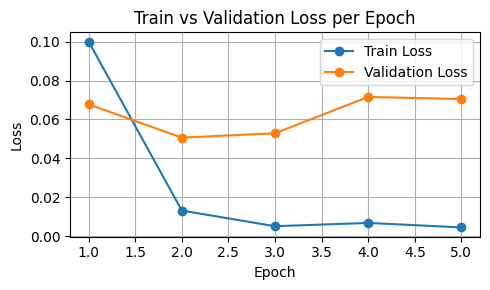

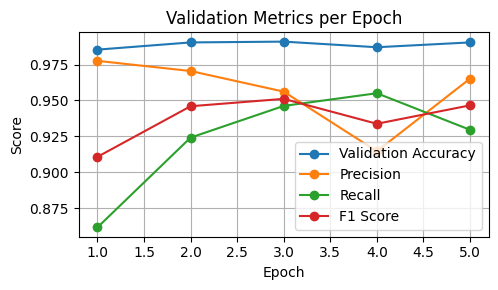

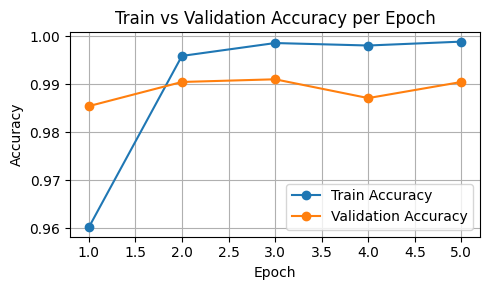

In [ ]:
plot_training_metrics(training_cnn)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def evaluate_model(model, dataloader, device, class_names=None, print_metrics=True, plot_cm=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

    # Create a dataframe with metrics
    metrics_df = pd.DataFrame({
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1-score': [f1]
    })

    if print_metrics:
        print(f"\nTest Evaluation:")
        print(metrics_df.to_string(index=False))
        print(f"\nConfusion Matrix:\n{cm}")
        print(f"\nClassification Report:\n{report}")

    if plot_cm:
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    return metrics_df, cm, report




Test Evaluation:
 Accuracy  Precision   Recall  F1-score
 0.991611    0.97178 0.935606   0.95289

Confusion Matrix:
[[1697    4]
 [  11   76]]

Classification Report:
              precision    recall  f1-score   support

         Neg     0.9936    0.9976    0.9956      1701
         Pos     0.9500    0.8736    0.9102        87

    accuracy                         0.9916      1788
   macro avg     0.9718    0.9356    0.9529      1788
weighted avg     0.9914    0.9916    0.9914      1788



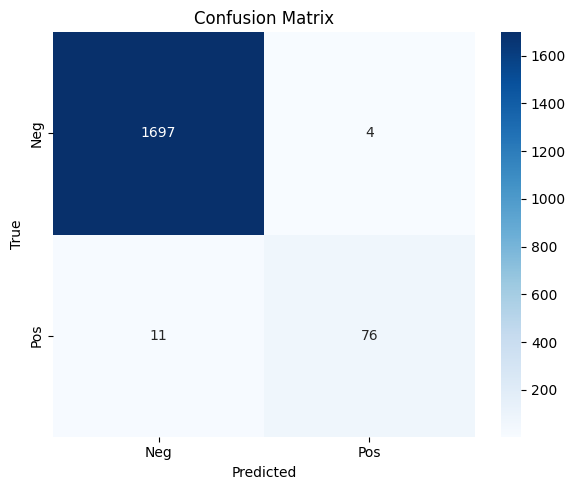

In [ ]:
test_cnn, cm_cnn, cf_report_cnn= evaluate_model(cnn_model, test_loader, device, class_names=['Neg', 'Pos'])

In [ ]:
print(cf_report_cnn)

              precision    recall  f1-score   support

         Neg     0.9936    0.9976    0.9956      1701
         Pos     0.9500    0.8736    0.9102        87

    accuracy                         0.9916      1788
   macro avg     0.9718    0.9356    0.9529      1788
weighted avg     0.9914    0.9916    0.9914      1788



## LSTM

In [ ]:
# Initialize your model, e.g., BERTLSTMClassifier
lstm_model = BERTLSTMClassifier(num_classes=2)
lstm_model.to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=2e-5)

# Train with early stopping and validation monitoring
history_lstm = train_model_with_val_earlystopping(
    lstm_model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=10, patience=3
)

Epoch 1/10 | Train Loss: 0.1209 | Val Loss: 0.1757 | Train Acc: 0.9539 | Val Acc: 0.9441 | Val F1: 0.7983
Epoch 2/10 | Train Loss: 0.0184 | Val Loss: 0.0531 | Train Acc: 0.9963 | Val Acc: 0.9888 | Val F1: 0.9353
Epoch 3/10 | Train Loss: 0.0109 | Val Loss: 0.0506 | Train Acc: 0.9974 | Val Acc: 0.9883 | Val F1: 0.9355
Epoch 4/10 | Train Loss: 0.0114 | Val Loss: 0.0488 | Train Acc: 0.9976 | Val Acc: 0.9877 | Val F1: 0.9357
Epoch 5/10 | Train Loss: 0.0098 | Val Loss: 0.0437 | Train Acc: 0.9977 | Val Acc: 0.9911 | Val F1: 0.9522
Epoch 6/10 | Train Loss: 0.0033 | Val Loss: 0.0469 | Train Acc: 0.9995 | Val Acc: 0.9922 | Val F1: 0.9568
Epoch 7/10 | Train Loss: 0.0066 | Val Loss: 0.0707 | Train Acc: 0.9985 | Val Acc: 0.9877 | Val F1: 0.9272
Epoch 8/10 | Train Loss: 0.0016 | Val Loss: 0.0576 | Train Acc: 0.9997 | Val Acc: 0.9905 | Val F1: 0.9500
Early stopping at epoch 8


In [ ]:
training_lstm = pd.DataFrame(history_lstm)
training_lstm

,epoch,train_loss,train_acc,val_loss,val_acc,val_precision,val_recall,val_f1
0,1,0.120907,0.953861,0.175666,0.944103,0.731111,0.954263,0.798327
1,2,0.018416,0.996253,0.053135,0.988821,0.968666,0.906871,0.935344
2,3,0.010917,0.997429,0.050590,0.988262,0.942910,0.928391,0.935515
3,4,0.011436,0.997649,0.048823,0.987703,0.922373,0.949910,0.935652
4,5,0.009827,0.997722,0.043671,0.991056,0.947379,0.957126,0.952194
5,6,0.003322,0.999522,0.046897,0.992174,0.967242,0.946807,0.956770
6,7,0.006589,0.998457,0.070707,0.987703,0.973344,0.889923,0.927163
7,8,0.001620,0.999706,0.057564,0.990497,0.938450,0.962286,0.950013


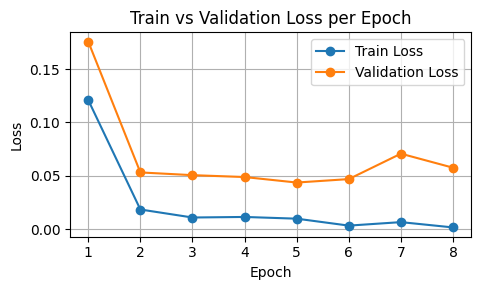

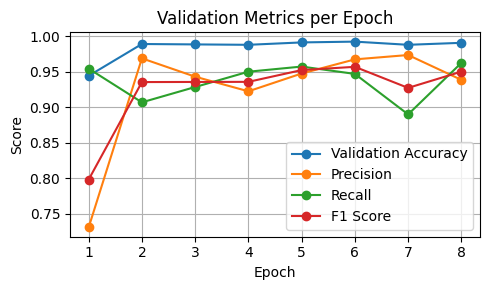

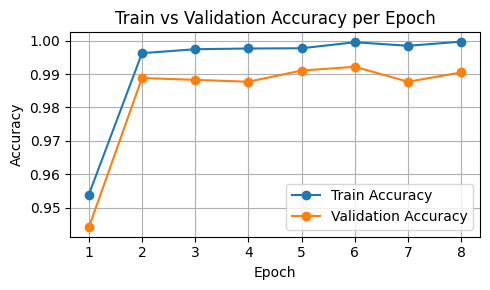

In [ ]:
plot_training_metrics(training_lstm)


Test Evaluation:
 Accuracy  Precision   Recall  F1-score
 0.991051   0.947378 0.957125  0.952193

Confusion Matrix:
[[1692    9]
 [   7   80]]

Classification Report:
              precision    recall  f1-score   support

         Neg     0.9959    0.9947    0.9953      1701
         Pos     0.8989    0.9195    0.9091        87

    accuracy                         0.9911      1788
   macro avg     0.9474    0.9571    0.9522      1788
weighted avg     0.9912    0.9911    0.9911      1788



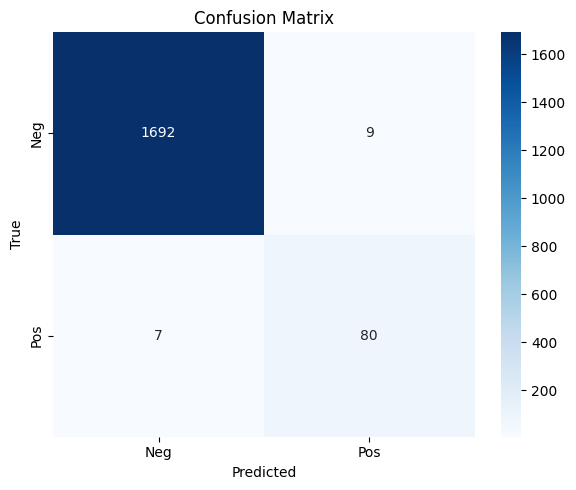

In [ ]:
test_lstm, cm_lstm,cf_report_lstm = evaluate_model(lstm_model, test_loader, device, class_names=['Neg', 'Pos'])

In [ ]:
print(cf_report_lstm)

              precision    recall  f1-score   support

         Neg     0.9959    0.9947    0.9953      1701
         Pos     0.8989    0.9195    0.9091        87

    accuracy                         0.9911      1788
   macro avg     0.9474    0.9571    0.9522      1788
weighted avg     0.9912    0.9911    0.9911      1788



## CNN-LSTM

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

# Initialize your model, e.g., BERTCNNLSTMClassifier
cnnlstm_model = BERTCNNLSTMClassifier(num_classes=2)
cnnlstm_model.to(device)

optimizer = torch.optim.Adam(cnnlstm_model.parameters(), lr=2e-5)

# Train with early stopping and validation monitoring
history_cnnlstm = train_model_with_val_earlystopping(
    cnnlstm_model, train_loader, val_loader, criterion, optimizer, device,
    num_epochs=10, patience=3
)

Epoch 1/10 | Train Loss: 0.0992 | Val Loss: 0.0497 | Train Acc: 0.9593 | Val Acc: 0.9899 | Val F1: 0.9474
Epoch 2/10 | Train Loss: 0.0103 | Val Loss: 0.0551 | Train Acc: 0.9972 | Val Acc: 0.9911 | Val F1: 0.9500
Epoch 3/10 | Train Loss: 0.0069 | Val Loss: 0.0520 | Train Acc: 0.9978 | Val Acc: 0.9922 | Val F1: 0.9572
Epoch 4/10 | Train Loss: 0.0057 | Val Loss: 0.0738 | Train Acc: 0.9985 | Val Acc: 0.9899 | Val F1: 0.9450
Early stopping at epoch 4


In [ ]:
training_cnnlstm = pd.DataFrame(history_cnnlstm)
training_cnnlstm

,epoch,train_loss,train_acc,val_loss,val_acc,val_precision,val_recall,val_f1
0,1,0.099170,0.959261,0.049743,0.989939,0.933715,0.961992,0.947351
1,2,0.010287,0.997208,0.055072,0.991056,0.965916,0.935313,0.950035
2,3,0.006858,0.997759,0.051982,0.992174,0.962358,0.952260,0.957247
3,4,0.005727,0.998457,0.073769,0.989939,0.950007,0.940179,0.945032


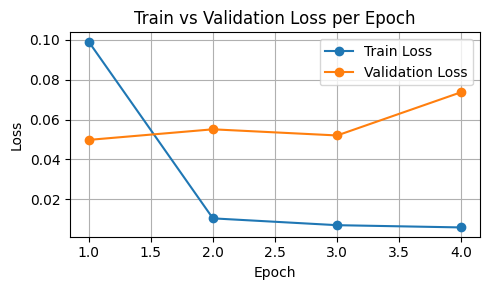

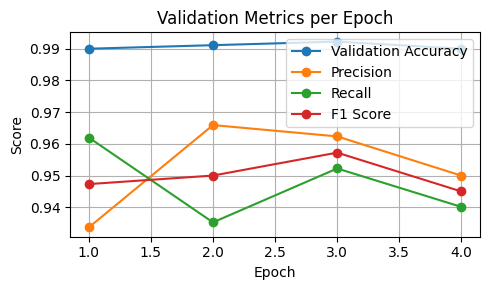

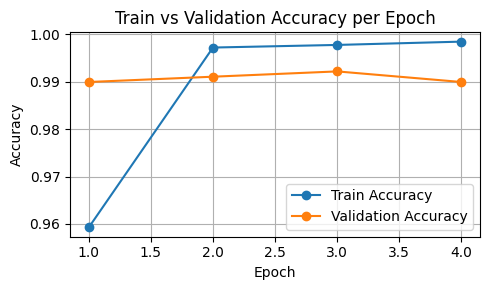

In [ ]:
plot_training_metrics(training_cnnlstm)


Test Evaluation:
 Accuracy  Precision   Recall  F1-score
 0.992729    0.96306 0.958006  0.960518

Confusion Matrix:
[[1695    6]
 [   7   80]]

Classification Report:
              precision    recall  f1-score   support

         Neg     0.9959    0.9965    0.9962      1701
         Pos     0.9302    0.9195    0.9249        87

    accuracy                         0.9927      1788
   macro avg     0.9631    0.9580    0.9605      1788
weighted avg     0.9927    0.9927    0.9927      1788



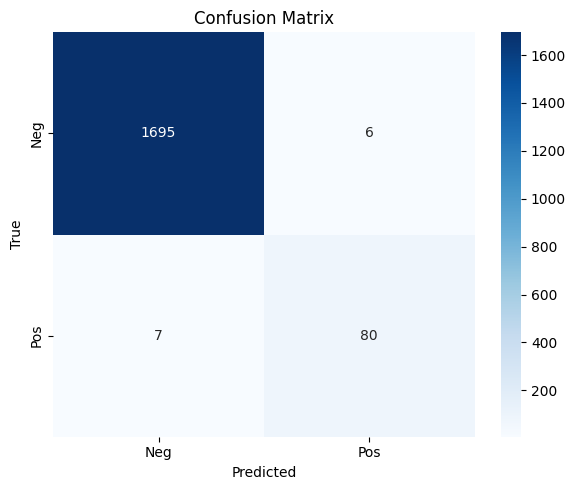

In [ ]:
test_cnnlstm, cm_cnnlstm,cf_report_cnnlstm = evaluate_model(cnnlstm_model, test_loader, device, class_names=['Neg', 'Pos'])

In [ ]:
print(cf_report_cnnlstm)

              precision    recall  f1-score   support

         Neg     0.9959    0.9965    0.9962      1701
         Pos     0.9302    0.9195    0.9249        87

    accuracy                         0.9927      1788
   macro avg     0.9631    0.9580    0.9605      1788
weighted avg     0.9927    0.9927    0.9927      1788



In [ ]:
# Assign model names to each DataFrame
test_cnn['model'] = 'CNN'
test_lstm['model'] = 'LSTM'
test_cnnlstm['model'] = 'CNN-LSTM'

# Concatenate and reset index
stat = pd.concat([test_cnn, test_lstm, test_cnnlstm], axis=0).reset_index(drop=True)
stat

,Accuracy,Precision,Recall,F1-score,model
0,0.991611,0.971780,0.935606,0.952890,CNN
1,0.991051,0.947378,0.957125,0.952193,LSTM
2,0.992729,0.963060,0.958006,0.960518,CNN-LSTM


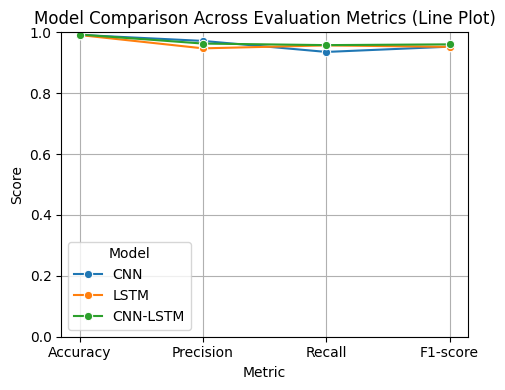

In [ ]:
stat_melted = stat.melt(id_vars='model',
                        value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'],
                        var_name='Metric',
                        value_name='Score')

# Plot line chart
plt.figure(figsize=(5, 4))
sns.lineplot(data=stat_melted, x='Metric', y='Score', hue='model', marker='o')
plt.title("Model Comparison Across Evaluation Metrics (Line Plot)")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title="Model")
plt.tight_layout()
plt.show()